## Figure of pool contours

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gspec
import matplotlib as mpl
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [3]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((19,360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

In [35]:
# Alongshore contours
def Plot1(gs_ax,Tr_slice,zslice,yslice,xslice,yind): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in x-z (nt,nz,nx)
       tslice: advective phase slice to average over.
       yind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    Trmin = 0
    Trmax = 11
    rho_min = 1020.4-1000.0
    rho_max = 1021.4-1000.0 # 1022.4 if y=230,1021.4 if y=260
    
    density = call_rho(tslice,yind,xslice)
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    #csU2 = np.linspace(rho_min,rho_max,num=15)
    
    Trplot = np.ma.array(np.nanmean(Tr_slice.isel(T=tslice).data,0),mask=MaskC[:,yind,:])
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Z[zslice],Trplot[zslice,:],csU,cmap=cmo.cm.tempo)
    
    #cax,kw = mpl.colorbar.make_axes([ax],location='right',anchor=(1,0),shrink=1.1)
    #cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f',**kw)
    
    CS = ax.contour(grid.X[xslice]/1000,grid.Z[zslice],
                     Trplot[zslice,:],
                     csU2,colors='k',linewidths=[0.75] )
    plt.clabel(CS,inline=True, fmt='%.1f')
    
    #CS = ax.contour(grid.X[xslice]/1000,grid.Z[:22],
    #                 np.ma.array(np.nanmean(density[:,:22,:].data-1000,axis=0),mask=MaskC[:22,yind,:]),
    #                 csU2,colors='k',linewidths=[0.75] )
    #plt.clabel(CS,inline=True, fmt='%.1f')
    
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.text(0.0,0.95,'Tr anom (Mol/l)',transform=ax.transAxes)
    

In [38]:
# Cross-shelf velocity, Plot1
def Plot2(gs_ax,Tr_slice,yslice,zslice,xind): 
    '''gs_ax: grid handle
       Tr_slice: tracer concentration sliced in y-z (nt,nz,ny)
       tslice: advective phase slice to average over.
       xind: cross-shore index of the plot
    '''
    ax = plt.subplot(gs_ax)
    Trmin = 0
    Trmax = 11
    rho_min = 1020.4-1000.0
    rho_max = 1021.4-1000.0 # 1022.4 if y=230,1021.4 if y=260
    
    density = call_rho(tslice,yslice,xind)
    csU = np.linspace(Trmin,Trmax,num=31)
    csU2 = np.linspace(Trmin,Trmax,num=16)
    #csU2 = np.linspace(rho_min,rho_max,num=15)
    
    Trplot = np.ma.array(np.nanmean(Tr_slice.isel(T=tslice).data,0),mask=MaskC[:,:,xind])
    mesh = ax.contourf(grid.Y[yslice]/1000,grid.Z[zslice],(Trplot[zslice,yslice]),csU,cmap=cmo.cm.tempo)
    
    #cax,kw = mpl.colorbar.make_axes([ax],location='right',anchor=(1,0),shrink=1.1)
    #cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(Trmin, Trmax,8) ],format='%.1f',**kw)
    
    CS = ax.contour(grid.Y[yslice]/1000,grid.Z[zslice],
                     (Trplot[zslice,yslice]),
                     csU2,colors='k',linewidths=[0.75] )
    plt.clabel(CS,inline=True, fmt='%.1f')
    
    #CS = ax.contour(grid.X[xslice]/1000,grid.Z[:22],
    #                 np.ma.array(np.nanmean(density[:,:22,:].data-1000,axis=0),mask=MaskC[:22,yind,:]),
    #                 csU2,colors='k',linewidths=[0.75] )
    #plt.clabel(CS,inline=True, fmt='%.1f')
    
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax.set_ylabel('Depth (m)',labelpad=0.3)
    ax.set_xlabel('Corss-shelf distnce (km)',labelpad=0.3)
    
    ax.text(0.0,0.95,'Tr (Mol/l)',transform=ax.transAxes)
    

In [23]:
def Plot3(gs_ax,ConcFilt,tslice,xslice,yslice,xind,yind):
    
    ax = plt.subplot(gs_ax)
    BAC = np.nanmean(ConcFilt[tslice,yslice,xslice],axis=0)
    
    maxCM = np.max(BAC)
    minCM = np.min(BAC)
    
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,BAC,21, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmo.cm.tempo)
    CS = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,BAC,11,
                    colors='k',linewidths=[0.75] )
    plt.clabel(CS,inline=True, fmt='%.1f')
    
    #cax,kw = mpl.colorbar.make_axes([ax],location='right',anchor=(5,0),shrink=1.1)
    #cb = plt.colorbar(mesh, cax=cax,ticks=[np.linspace(minCM, maxCM,8) ],format='%.2f',**kw)
       
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    
    ax.text(0.6,0.1,'BAC (Mol/l)',transform=ax.transAxes)
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.axhline(grid.Y[yind]/1000,color='k',linestyle='--')
    ax.axvline(grid.X[xind]/1000,color='k',linestyle='--')
    
    ax.set_xlabel('Alongshore distance (km)',labelpad=0.3)
    ax.set_ylabel('Cross-shore distance (km)',labelpad=0.3)

In [6]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [28]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xslice=slice(0,360)
yslice=slice(100,300)

tslice = slice(8,16)

xind = 180
yind = 267 # y index for alongshore cross-section
zind = 27

# plot2
zslice_2 = slice(0,32)
# plot 3
yslice_bac = slice(200,300)
xslice_bac = slice(100,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr1).shape)    

In [8]:
ConcArea, ConcFilt, Area = ConcArea(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19, 360, 360)


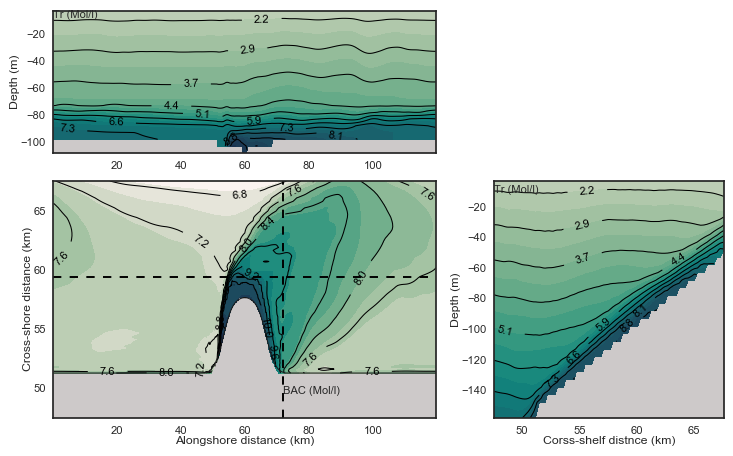

In [39]:
sns.set_context('paper')
sns.set_style('white')

plt.rcParams['font.size'] = 8.0

f = plt.figure(figsize = (7.4,4.6)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 2, height_ratios=[0.6,1], width_ratios=[1,0.6])

Plot1(gs0[0,0],ptracers.Tr1.isel(Y=267)) # x-z contours conc

Plot2(gs0[1,1],ptracers.Tr1.isel(X=250),yslice_bac,zslice_2,250) # bottom concentration

Plot3(gs0[1,0],ConcFilt,tslice,xslice,yslice_bac,250,267)



plt.tight_layout()

plt.savefig('fig_BottomConcBase.pdf',format='pdf')
